##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 卷积变分自编码器

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/cvae">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png">     在 TensorFlow.org 上查看</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/cvae.ipynb">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">     在 Google Colab 中运行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/cvae.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/cvae.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载 notebook</a>   </td>
</table>

此笔记本演示了如何基于 MNIST 数据集训练变分自编码器 (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082))。VAE 是一种自编码器取值的概率分布，该模型会获取高维输入数据并将其压缩为较小的表示。与将输入映射到隐向量的传统自编码器不同，VAE 会将输入数据映射到概率分布的参数中，例如高斯分布的均值和方差。这种方式可以生成一个连续、结构化的隐空间，对于图像生成而言十分适用。

![CVAE 图像隐空间](https://gitlocalize.com/repo/4592/zh-cn/site/en-snapshot/tutorials/generative/images/cvae_latent_space.jpg)

## 导入 Tensorflow 与其他库

In [2]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vpcyuycm
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vpcyuycm
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184155 sha256=642ce041b28022b82db913ae9fa44b006e62e30eb0ef521b71a864e9a708e86f
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2wdn108/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## 加载 MNIST 数据集

每个 MNIST 图像最初都是一个由 784 个整数组成的向量，每个整数在 0-255 之间，代表一个像素的强度。在我们的模型中使用伯努利分布对每个像素进行建模，并对数据集进行静态二值化。

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
train_size = 60000
batch_size = 32
test_size = 10000

## 使用 *tf.data* 来将数据分批和打乱

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## 通过 *tf.keras.Sequential* 连接生成网络与推理网络

在此 VAE 示例中，对编码器和解码器网络使用两个小型 ConvNet。在文献中，这些网络也分别称为推断/识别和生成模型。使用 `tf.keras.Sequential` 来简化实现。在下面的描述中，使 $x$ 和 $z$ 分别表示观测值和隐变量。

### 生成网络

这定义了近似后验分布 $q(z|x)$，它会将输入取作观测值并输出一组参数，用于指定隐变量表示 $z$ 的条件分布。在本例中，简单地将分布建模为对角高斯分布，网络会输出分解高斯分布的均值和对数方差参数。输出对数方差而不是直接用于数值稳定性的方差。

### 推理网络

这定义了观测值的条件分布 $p(x|z)$，它会将隐变量样本 $z$ 取作输入并输出观测值条件分布的参数。将隐变量先验分布 $p(z)$ 建模为单位高斯分布。

### 重参数化技巧

要在训练期间为解码器生成样本 $z$，您可以在给定输入观测值 $x$ 的情况下从编码器输出的参数所定义的隐变量分布中采样。然而，这种采样操作会产生瓶颈，因为反向传播不能流经随机节点。

要解决这个问题，请使用重参数化技巧。在我们的示例中，使用解码器参数和另一个参数 $\epsilon$ 来逼近 $z$，如下所示：

$$z = \mu + \sigma \odot \epsilon$$

其中 $\mu$ 和 $\sigma$ 分别代表高斯分布的均值和标准差。它们可通过解码器输出推导得出。$\epsilon$ 可被认为是用于保持 $z$ 的随机性的随机噪声。从标准正态分布生成 $\epsilon$。

隐变量 $z$ 现在由 $\mu$、$\sigma$ 和 $\epsilon$ 的函数生成，这将使模型能够分别通过 $\mu$ 和 $\sigma$ 在编码器中反向传播梯度，同时通过 $\epsilon$ 保持随机性。

### 网络架构

对于编码器网络，使用两个卷积层后接一个全连接层。在解码器网络中，通过使用一个全连接层后接三个卷积转置层（在某些背景下也称为反卷积层）来镜像此架构。请注意，通常的做法是在训练 VAE 时避免使用批量归一化，因为使用 mini-batch 导致的额外随机性可能会在提高采样随机性的同时加剧不稳定性。


In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 定义损失函数和优化器

VAE 通过最大化边际对数似然的证据下界（ELBO）进行训练：

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

在实践中，优化此期望的单样本蒙特卡罗估值：

$$\log p(x| z) + \log p(z) - \log q(z|x)$$，其中 $z$ 从 $q(z|x)$ 中采样。

注：您也可以分析计算 KL 项，但为了简单起见，您在此处会将三个项全部应用到蒙特卡罗 Estimator 中。

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 训练

- 首先迭代数据集
- 在每次迭代期间，将图像传递给编码器以获取近似后验分布 $q(z|x)$ 的一组均值和对数方差参数
- 然后，应用*重参数化技巧*以从 $q(z|x)$ 中采样
- 最后，将重参数化的样本传递给解码器以获取生成分布 $p(x|z)$ 的 logit
- 注：由于您使用由 Keras 加载的数据集，训练集中有 6 万个数据点，测试集中有 1 万个数据点，因此我们基于测试集得出的 ELBO 会略高于使用 Larochelle 的 MNIST 动态二值化的文献中报告的结果。

### 生成图像

- 进行训练后，可以生成一些图片了
- 首先从单位高斯先验分布 $p(z)$ 中采样一组隐向量
- 随后生成器将潜在样本 $z$ 转换为观测值的 logit，得到分布 $p(x|z)$
- 在此处，绘制伯努利分布的概率分布图


In [10]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.7230682373047, time elapse for current epoch: 4.775113582611084


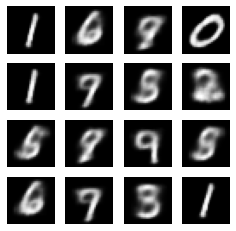

In [13]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### 使用 epoch 编号显示图片

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

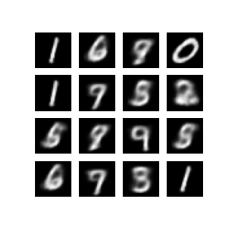

In [15]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### 生成所有保存图片的 GIF

In [20]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [21]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

TypeError: ignored

### 显示隐空间中数字的二维流形

运行下面的代码将显示不同数字类的连续分布，每个数字都会在二维隐空间中变形为另一数字。使用 [TensorFlow Probability](https://tensorflow.google.cn/probability) 为隐空间生成标准正态分布。

In [18]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

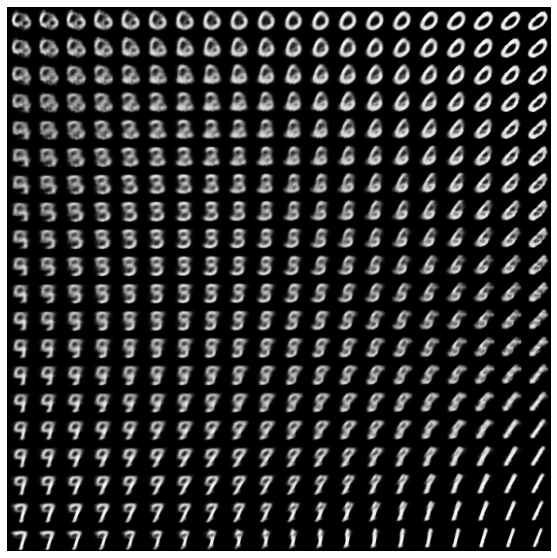

In [19]:
plot_latent_images(model, 20)

## 后续步骤

本教程演示了使用 TensorFlow 实现卷积变分自编码器的方式。

下一步，您可以尝试通过增大网络来改进模型输出。例如，您可以尝试将每个 `Conv2D` 和 `Conv2DTranspose` 层的 `filter` 参数设置为 512。请注意，为了生成最终的二维隐空间图像，您需要将 `latent_dim` 保持为 2。此外，训练时间会随网络的增大而延长。

您还可以尝试使用不同的数据集实现 VAE，例如 CIFAR-10。

VAE 支持以多种不同的风格和不同的复杂性实现。您可以从以下资源中找到其他实现：

- [变分自编码器 (keras.io)](https://keras.io/examples/generative/vae/)
- [“编写自定义层和模型”指南中的 VAE 示例 (tensorflow.org)](https://tensorflow.google.cn/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP 概率层：变分自动编码器](https://tensorflow.google.cn/probability/examples/Probabilistic_Layers_VAE)

如果您想了解有关 VAE 的更多详细信息，请参阅[变分自编码器简介](https://arxiv.org/abs/1906.02691)。